# Time series prediction using LSTM

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print(tf.__version__)

2.4.1


## Dataset
- Daily minimum temperatures in Melbourne, Australia, 1981-1990
- Units: Degrees Celcius

## Question 1

### Load the data
- load daily-minimum-temperatures-in-me.csv

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving daily-minimum-temperatures-in-me.csv to daily-minimum-temperatures-in-me.csv
User uploaded file "daily-minimum-temperatures-in-me.csv" with length 55995 bytes


In [3]:
!ls -l

total 64
-rw-r--r-- 1 root root 55995 Feb 28 07:58 daily-minimum-temperatures-in-me.csv
drwx------ 5 root root  4096 Feb 28 03:43 drive
drwxr-xr-x 1 root root  4096 Feb 24 17:49 sample_data


In [4]:
df = pd.read_csv('daily-minimum-temperatures-in-me.csv')

### Print the data
- First 5 rows only

In [5]:
df.head()

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


### Set index column
- Set the DataFrame index using "Date" column

In [6]:
df = df.set_index('Date')

## Question 2

### Check the total count of null values in the data

In [7]:
df.isnull().sum()

Temperature    0
dtype: int64

### Drop all the rows with null values
- use dropna() method

In [8]:
df.dropna(inplace=True)

## Question 3

### Describe your dataframe
- use describe() method

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,3650.0,11.177753,4.071837,0.0,8.3,11.0,14.0,26.3


### Plot the dataframe
- use plot() method

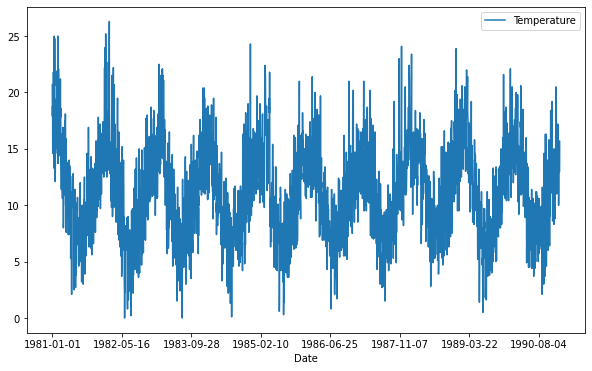

In [10]:
df.plot(figsize=(10,6))
plt.show()

### Get representation of the distribution of data using histogram
- use hist() method

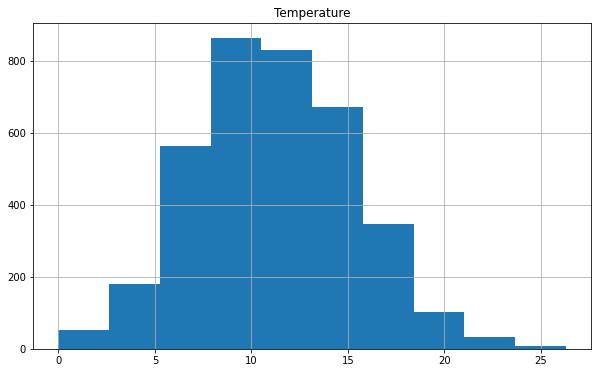

In [11]:
df.hist(figsize=(10,6))
plt.show()

### Check minimum and maximum temperature
- use min() and max() methods

In [12]:
df.min()

Temperature    0.0
dtype: float64


In [13]:
df.max()

Temperature    26.3
dtype: float64


## Question 4

### Split the dataset into training and testing
- training data: 75%
- testing data: 25%

In [14]:
train = df[ : int(len(df)*0.75)]
test = df[int(len(df)*0.75) : len(df)]

In [15]:
print(train.shape, test.shape)

(2737, 1) (913, 1)


### Normalize the data
- normalize temperature values using MinMaxScaler
- feature_range: 0-1
- fit MinMaxScaler on train data and transform it
  - use fit_transform() method
- transform test data using MinMaxScaler object
  - use transform() method

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train)
test = scaler.transform(test)

### Print scaled train and test data
- print only first 5 values

In [17]:
train[:5]

array([[0.78707224],
       [0.68060837],
       [0.7148289 ],
       [0.55513308],
       [0.60076046]])

In [18]:
test[:5]

array([[0.22813688],
       [0.22053232],
       [0.18631179],
       [0.19011407],
       [0.31939163]])

## Question 5

### Create sequential data
Map the temperature at a particular day 'd' to the temperature at day t
'd+n', where n is any number you define.

For example: to map temperatures of consecutive days, use d+1, i.e. lookback = 1
- Below function takes data as input and returns sequential data.
- X as features and y as labels

In [19]:
def create_seq_data(data, lookback=1):
    X, y = list(), list()
    
    for day in range((len(data)-lookback)):
        X.append(data[day: day+lookback, 0])
        y.append(data[day+lookback, 0])
    
    return np.array(X), np.array(y)

### Use the above function to create train and test sets
- Get X_train and y_train
- Get X_test and y_test
- look_back = 1

In [20]:
look_back = 7

In [21]:
X_train, y_train = create_seq_data(train, look_back)
X_train[:5], y_train[:5]

(array([[0.78707224, 0.68060837, 0.7148289 , 0.55513308, 0.60076046,
         0.60076046, 0.60076046],
        [0.68060837, 0.7148289 , 0.55513308, 0.60076046, 0.60076046,
         0.60076046, 0.66159696],
        [0.7148289 , 0.55513308, 0.60076046, 0.60076046, 0.60076046,
         0.66159696, 0.82889734],
        [0.55513308, 0.60076046, 0.60076046, 0.60076046, 0.66159696,
         0.82889734, 0.76045627],
        [0.60076046, 0.60076046, 0.60076046, 0.66159696, 0.82889734,
         0.76045627, 0.61596958]]),
 array([0.66159696, 0.82889734, 0.76045627, 0.61596958, 0.50570342]))

In [22]:
X_test, y_test = create_seq_data(test, look_back)

### Reshape the data
- Reshape X_train and X_test
- use np.reshape() method
- this is to be done to make the data ready for input in model

In [23]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Print shape of data
- print shape of X_train and X_test

In [24]:
print(X_train.shape)
print(X_test.shape)

(2730, 7, 1)
(906, 7, 1)


## Question 6

### Define sequential model
- initialize a Sequential model
- add an LSTM layer
  - units: 10
  - stateful: True
  - pass a `batch_input_shape` argument to your layer
  - batch_input_shape: (batch_size, look_back, 1)
    - batch_size: 1
    - look_back: 1
- add Dense layer with 1 neuron

In [25]:
units = 10
batch_size = 6

In [26]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units, stateful=True, batch_input_shape=(batch_size, look_back, 1)))
model.add(tf.keras.layers.Dense(1))

## Question 7

### compile your model
- loss: mean_squared_error
- optimizer: adam

In [27]:
model.compile(optimizer='adam', loss='mean_squared_error')

### summarize your model
- use summary() method

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (6, 10)                   480       
_________________________________________________________________
dense (Dense)                (6, 1)                    11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


## Question 8

### fit your model
- epochs: 50
- batch_size: 1

In [29]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=batch_size, verbose=1)

Epoch 1/50
455/455 [==============================] - 3s 5ms/step - loss: 0.0247 - val_loss: 0.0095
Epoch 2/50
455/455 [==============================] - 1s 3ms/step - loss: 0.0109 - val_loss: 0.0092
Epoch 3/50
455/455 [==============================] - 1s 3ms/step - loss: 0.0114 - val_loss: 0.0093
Epoch 4/50
455/455 [==============================] - 1s 3ms/step - loss: 0.0105 - val_loss: 0.0089
Epoch 5/50
455/455 [==============================] - 1s 3ms/step - loss: 0.0098 - val_loss: 0.0087
Epoch 6/50
455/455 [==============================] - 1s 3ms/step - loss: 0.0096 - val_loss: 0.0088
Epoch 7/50
455/455 [==============================] - 1s 3ms/step - loss: 0.0103 - val_loss: 0.0085
Epoch 8/50
455/455 [==============================] - 1s 3ms/step - loss: 0.0096 - val_loss: 0.0088
Epoch 9/50
455/455 [==============================] - 1s 3ms/step - loss: 0.0093 - val_loss: 0.0083
Epoch 10/50
455/455 [==============================] - 1s 3ms/step - loss: 0.0093 - val_loss: 0.0083

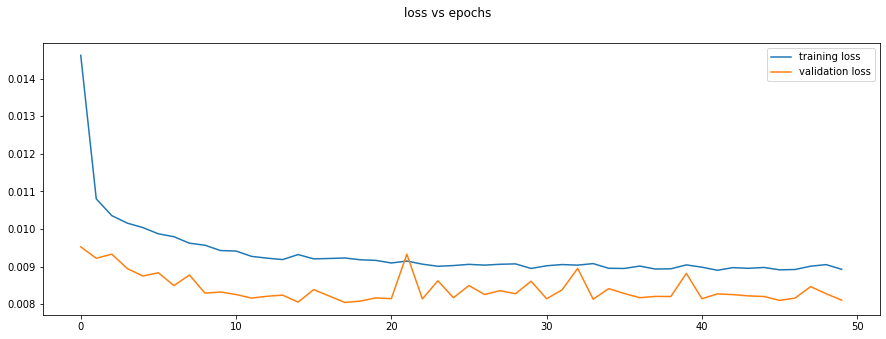

In [30]:
fig, (ax) = plt.subplots(1, 1, figsize=(15, 5))
fig.suptitle('loss vs epochs')
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.legend(['training loss', 'validation loss'], loc='best')
plt.show()

## Question 9

### make predictions on train data
- use predict() method
  - batch_size: 1
- store predictions in a variable

In [31]:
train_pred = model.predict(X_train, batch_size=batch_size)

In [32]:
train_pred[0:5]

array([[0.60083055],
       [0.6293239 ],
       [0.71729445],
       [0.67244875],
       [0.60615414]], dtype=float32)

### reset model state
- if you are using stateful=True in your model then you should call reset_states every time, when you want to make consecutive model calls independent.
- use reset_states() method

In [33]:
model.reset_states()

### make predictions on test data
- use predict() method
  - batch_size: 1
- store predictions in a variable

In [34]:
test_pred = model.predict(X_test, batch_size=batch_size)

In [35]:
test_pred[0:5]

array([[0.3830325 ],
       [0.3750271 ],
       [0.30029133],
       [0.32241318],
       [0.4235818 ]], dtype=float32)

## Question 10

### Inverse train predictions and true labels
- use your MinMaxSclarer object
- use inverse_transform() method

In [36]:
train_pred = scaler.inverse_transform(train_pred)
train_pred[:5]

array([[15.801844],
       [16.551218],
       [18.864843],
       [17.685402],
       [15.941854]], dtype=float32)

In [37]:
y_train = scaler.inverse_transform([y_train])

### Inverse test predictions and true labels
- use your MinMaxSclarer object
- use inverse_transform() method

In [38]:
test_pred = scaler.inverse_transform(test_pred)
test_pred[:5]

array([[10.073754],
       [ 9.863213],
       [ 7.897662],
       [ 8.479466],
       [11.140202]], dtype=float32)

In [39]:
y_test = scaler.inverse_transform([y_test])

### Evaluate train predictions
- calculate RMSE
- RMSE = sqrt(mean_squared_error(true_labels, predicted_labels))
- use sqrt() and mean_squared_error() method
- print training RMSE

In [40]:
train_RMSE = np.sqrt(tf.keras.losses.mean_squared_error(y_train[0], train_pred[:,0]))
print('Train RMSE = ', round(train_RMSE, 2))

Train RMSE =  2.48


### Evaluate test predictions
- calculate RMSE
- RMSE = sqrt(mean_squared_error(true_labels, predicted_labels))
- use sqrt() and mean_squared_error() method
- print testing RMSE

In [41]:
test_RMSE = np.sqrt(tf.keras.losses.mean_squared_error(y_test[0], test_pred[:,0]))
print('Train RMSE = ', round(test_RMSE, 2))

Train RMSE =  2.37


---